# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

### Carregamento dos pacotes necessários 
Os pacotes necessários para esta tarefa são:
- Pandas para leitura e modificação dos dados;
- Numpy que permite operações matemáticas;
- Matplotlib.pyplot para a geração de gráficos;
- seaborn para visualização de gráficos estatísticos;
- statsmodels.formula.api para o ajuste da regressão logística aos conjunto de dados;
- Função metrics do pacote sklearn, para o cálculo da acurácia e do gini do ajuste da regressão;
- Função ks_2samp do pacote scipy.stats, para calcular o KS do ajuste.

In [193]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
from sklearn import metrics
from scipy.stats import ks_2samp

### Carregamento da base de dados
A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

Para facilitar a análise, vamos criar uma nova coluna booleana 'flag_doente', onde tem o valor zero se a pessoa é saudável, e 1 se a pessoa tem alguma doença cardíaca.

In [194]:
# URL da base de dados
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

# Cria a tabela com os dados presentes na URL, e nomeia as colunas de acordo com a variável
df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])

# Cria uma nova coluna onde especifica se a pessoa está doente (1) ou não (0)
df['flag_doente'] = (df['num']!=0).astype('int64')

# Mostra as 5 primeiras linhas da tabela
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


Verifiquemos mais detalhes sobre a tabela carregada, como os tipos de dados que há em cada coluna, se há valores nulos ou duplicados, além de ver a descrição estatística de cada variável numérica.

In [195]:
# Imprime o número de linhas não nulas e qual tipo de dado encontra-se em cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


Os resultados mostram que maior parte das variáveis são numéricas e que nenhuma delas apresenta dados nulas. Por precaução, vejamos o número total de valores nulos em cada uma.

In [196]:
# Imprime o número de valores nulos em cada coluna
df.isna().sum()

age            0
sex            0
cp             0
trestbps       0
chol           0
fbs            0
restecg        0
thalach        0
exang          0
oldpeak        0
slope          0
ca             0
thal           0
num            0
flag_doente    0
dtype: int64

Foi confirmado que não há dados faltantes na tabela. Vamos conferir agora se há dados duplicados.

In [197]:
# Obtém o número de linhas duplicadas na base de dados
duplicados = df.duplicated().sum()

# Imprime o número resultante
print("Há {} linhas duplicadas na base de dados.".format(duplicados))

Há 0 linhas duplicadas na base de dados.


Foi observado que não há linhas duplicadas nesta base de dados. Vejamos a distribuição de valores de cada variável.

In [198]:
# Retorna a descrição estatística de cada variável
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num,flag_doente
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000,1.000000


A descrição estatística do dataframe não retornou dados sobre as variáveis 'ca' e 'thal', uma vez que estas são categóricas. Vejamos os valores nelas presentes.

In [199]:
# Contagem de valores da variável 'ca'
df['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

In [200]:
# Contagem de valores da variável 'thal'
df['thal'].value_counts()

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64

Ambas as variáveis apresentam valores nulos, representados pelo símbolo '?'. Vejamos quais são essas linhas.

In [201]:
# Seleciona as linhas que estão com valores inválidos
invalidos = df[(df['thal'] == '?') | (df['ca'] == '?')]

# Conta o número de linhas com valores inválidos
n_linhas = len(invalidos)

# Calcula a porcentagem dessas linhas em relação ao total
pct_invalidos = n_linhas/len(df)

# Imprime o número de linhas inválidas e qual a porcentagem delas em relação ao total
print(f'Há {n_linhas} linhas com valores inválidos, {100*pct_invalidos:.1f}% do total.')

# Mostra as linhas
invalidos

Há 6 linhas com valores inválidos, 2.0% do total.


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0,0


Visto que apenas 2% das linhas apresenta dados inválidos, vamos removê-las do dataframe.

In [202]:
# Remove as linhas inválidas do dataframe
df = df[(df['thal'] != '?') & (df['ca'] != '?')]

# Mostra o dataframe resultante
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

Seja bivariada_qualitativa a função que obedece às condições descritas acima. Ela encontra-se definida logo abaixo.

In [203]:
def bivariada_qualitativa(df: pd.DataFrame, resposta: str, explicativa: str) -> pd.DataFrame:
    '''
    Esta função faz a tabela cruzada das variáveis qualitativas 'resposta' e 'explicativa'
    presentes no dataframe 'df'. Na tabela cruzada são inseridas as colunas: 
    - 'Média 0' com os valores da média do 'não evento' da variável resposta em relação à 
    explicativa;
    - 'Média 1' com os valores da média do 'evento' da variável resposta em relação à 
    explicativa;
    - 'Odds' com o número de chances que o 'evento' tem em relação a cada linha da variável
    explicativa;
    - 'RC', com as taxas de chances em relação ao total;
    - 'Logito', com os valores dos logaritmos das chances;
    - 'WOE', onde estão os valores dos logaritmos das taxas de chance.
    Após os cálculos de cada coluna, a tabela cruzada é retornada para o usuário.
    '''
    
    # Monta a tabela cruzada entre a variáveis explicativa e resposta
    bivariada = pd.crosstab(index=df[explicativa], columns=df[resposta], margins=True)
    
    # Cria as colunas com as médias do 'evento' e do 'não evento' em relação ao total
    bivariada['Média 0'] = bivariada[0]/bivariada['All']
    bivariada['Média 1'] = bivariada[1]/bivariada['All']
    
    # Calula as chances do 'evento' em relação ao 'não evento'
    bivariada['Odds'] = bivariada[1]/bivariada[0]
    
    # Calcula a taxa de chances em relação ao total
    bivariada['RC'] = bivariada['Odds']/bivariada.loc['All', 'Odds']
    
    # Coluna com os valores de logito
    bivariada['Logito'] = np.log(bivariada['Odds'])
    
    # Coluna com os valores de WOE
    bivariada['WOE'] = np.log(bivariada['RC'])
    
    #Retorna a tabela cruzada resultante
    return bivariada

Com a função de análise bivariada para variáveis qualitativas pronta, façamos as análises das variáveis 'sex' (sexo do paciente), 'cp' (tipo de dor no peito) e 'fbs' (presença de açúcar no sangue em jejum).

In [204]:
# Realiza a análise bivariada da variável 'flag_doente' em relação a 'sex'
sexo = bivariada_qualitativa(df=df, resposta='flag_doente', explicativa='sex')
sexo

flag_doente,0,1,All,Média 0,Média 1,Odds,RC,Logito,WOE
sex,,,,,,,,,
0.0,71,25,96,0.739583,0.260417,0.352113,0.411226,-1.043804,-0.888611
1.0,89,112,201,0.442786,0.557214,1.258427,1.469696,0.229863,0.385055
All,160,137,297,0.538721,0.461279,0.856250,1.000000,-0.155193,0.000000


Na coluna 'sex', a linha com o valor 1.0 representa pessoas do sexo masculino, enquanto que 0.0 são pessoas do sexo feminino. Comparando os valores da coluna 'Média 1' para cada um dos sexos, vemos que a média de homens estarem doentes é superior ao dobro da média de mulheres doentes. A coluna 'Odds' ressalta que a chance de um indivíduo do sexo masculino apresentar alguma doença cardíaca é 4 vezes maior do que uma pessoa do sexo feminino estar doente. 

Façamos a mesma análise bivariada considerando o tipo de dor que a pessoa apresenta ('cp').

In [205]:
# Realiza a análise bivariada da variável 'flag_doente' em relação a 'cp'
dor_peito = bivariada_qualitativa(df=df, resposta='flag_doente', explicativa='cp')
dor_peito

flag_doente,0,1,All,Média 0,Média 1,Odds,RC,Logito,WOE
cp,,,,,,,,,
1.0,16,7,23,0.695652,0.304348,0.437500,0.510949,-0.826679,-0.671486
2.0,40,9,49,0.816327,0.183673,0.225000,0.262774,-1.491655,-1.336462
3.0,65,18,83,0.783133,0.216867,0.276923,0.323414,-1.284016,-1.128823
4.0,39,103,142,0.274648,0.725352,2.641026,3.084410,0.971167,1.126360
All,160,137,297,0.538721,0.461279,0.856250,1.000000,-0.155193,0.000000


Na variável 'cp' os valores entre 1.0 e 3.0 representam algum tipo de dor no peito, enquanto que o valor 4.0 representa pacientes assintomáticos. Ironicamente, a média de pessoas com alguma doença cardíaca assintomática foi a maior das quatro, sendo próxima a 73%, enquanto que os casos de pessoas com algum tipo de dor variaram entre 18% e 30%. Dessa forma, vemos que pessoas sem dor no peito são as que mais têm tendências a doenças cardíacas.  

In [206]:
# Realiza a análise bivariada da variável 'flag_doente' em relação a 'fbs'
acucar = bivariada_qualitativa(df=df, resposta='flag_doente', explicativa='fbs')
acucar

flag_doente,0,1,All,Média 0,Média 1,Odds,RC,Logito,WOE
fbs,,,,,,,,,
0.0,137,117,254,0.539370,0.460630,0.854015,0.997389,-0.157807,-0.002614
1.0,23,20,43,0.534884,0.465116,0.869565,1.015551,-0.139762,0.015431
All,160,137,297,0.538721,0.461279,0.856250,1.000000,-0.155193,0.000000


A presença de açúcar no sangue em jejum ('fbs') não apresentou diferenças significativas nos valores médios de pessoas com alguma doença. As chances de pessoas com ou sem açúcar no sangue terem alguma doença também não tiveram diferenças significativas, variando entre 83% e 96%.

Das três variáveis analisadas, a que mais diferenciou pessoas com algum tipo de doença cardíaca foi a 'cp', com maiores ocorrências em pessoas assintomáticas; em 2º lugar foi a variável 'sex', com maior número de doenças em homens.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [207]:
def bivariada_quantitativa(df: pd.DataFrame, resposta: str, explicativa: str, default=5) -> pd.DataFrame:
    '''
    Esta função faz a tabela cruzada das variáveis qualitativa 'resposta' e quantitativa
    'explicativa' presentes no dataframe 'df'.Nesta tabela, a variável explicativa é dividida
    no número de grupos definido no parâmetro 'default', tendo como padrão o valor 5. Na 
    tabela cruzada são inseridas as colunas: 
    - 'Média 0' com os valores da média do 'não evento' da variável resposta em relação à 
    explicativa;
    - 'Média 1' com os valores da média do 'evento' da variável resposta em relação à 
    explicativa;
    - 'Odds' com o número de chances que o 'evento' tem em relação a cada linha da variável
    explicativa;
    - 'RC', com as taxas de chances em relação ao total;
    - 'Logito', com os valores dos logaritmos das chances;
    - 'WOE', onde estão os valores dos logaritmos das taxas de chance;
    - 'Média grupo' com os valores médios de cada grupo da variável quantitativa.
    Após os cálculos de cada coluna, a tabela cruzada é retornada para o usuário.
    '''
    
    # Divide a variável explicativa quantitativa no número de grupos definido em default
    grupos = pd.qcut(x=df[explicativa], q=default)
    
    # Monta a tabela cruzada entre a variáveis resposta e os grupos da explicativa
    bivariada = pd.crosstab(index=grupos, columns=df[resposta], margins=True)
    
    # Cria as colunas com as médias do 'evento' e do 'não evento' em relação ao total
    bivariada['Média 0'] = bivariada[0]/bivariada['All']
    bivariada['Média 1'] = bivariada[1]/bivariada['All']
    
    # Calula as chances do 'evento' em relação ao 'não evento'
    bivariada['Odds'] = bivariada[1]/bivariada[0]
    
    # Calcula a taxa de chances em relação ao total
    bivariada['RC'] = bivariada['Odds']/bivariada.loc['All', 'Odds']
    
    # Coluna com os valores de logito
    bivariada['Logito'] = np.log(bivariada['Odds'])
    
    # Coluna com os valores de WOE
    bivariada['WOE'] = np.log(bivariada['RC'])
    
    # Obtém os valores médios de cada grupo
    bivariada['Média grupo'] = df.groupby(by=pd.qcut(x=df[explicativa],q=5)).mean()[explicativa]
    
    # Obtém a média total da variável explicativa
    bivariada.loc['All', 'Média grupo'] = df[explicativa].mean()
    
    #Retorna a tabela cruzada resultante
    return bivariada

Com a nova função de análise bivariada para variáveis quantitativas, analisemos algumas destas variáveis presentes na tabela. No caso, as três variáveis selecionadas foram 'age' (idade), 'trestbps' (pressão sanguínea em repouso) e 'chol' (colesterol sérico).

Começando pela idade dos pacientes:

In [208]:
# Realiza a análise bivariada da variável 'flag_doente' em relação a 'age'
idade = bivariada_quantitativa(df=df, resposta='flag_doente', explicativa='age')
idade

flag_doente,0,1,All,Média 0,Média 1,Odds,RC,Logito,WOE,Média grupo
age,,,,,,,,,,
"(28.999, 45.0]",46,15,61,0.754098,0.245902,0.326087,0.380831,-1.120591,-0.965398,41.245902
"(45.0, 53.0]",40,21,61,0.655738,0.344262,0.525000,0.613139,-0.644357,-0.489164,49.885246
"(53.0, 58.0]",31,39,70,0.442857,0.557143,1.258065,1.469272,0.229574,0.384767,56.185714
"(58.0, 62.8]",13,32,45,0.288889,0.711111,2.461538,2.874789,0.900787,1.055979,60.355556
"(62.8, 77.0]",30,30,60,0.500000,0.500000,1.000000,1.167883,0.000000,0.155193,66.516667
All,160,137,297,0.538721,0.461279,0.856250,1.000000,-0.155193,0.000000,54.542088


A média de pessoas com alguma doença cardíaca é maior na faixa de idades entre 58 e 62 anos, sendo esta, também, a faixa em que a chance de uma pessoa estar doente é máxima (próxima a 2.5). Por outro lado, há menor quantidade de ocorrências na faixa entre 29 e 45 anos (média de 75% dos pacientes não doentes), com uma chance de 34% de encontrar uma pessoa doente nesta faixa.

Relação entre doenças cardíacas e pressão sanguínea:

In [209]:
# Realiza a análise bivariada da variável 'flag_doente' em relação a 'trestbps'
pressao = bivariada_quantitativa(df=df, resposta='flag_doente', explicativa='trestbps')
pressao

flag_doente,0,1,All,Média 0,Média 1,Odds,RC,Logito,WOE,Média grupo
trestbps,,,,,,,,,,
"(93.999, 118.4]",37,23,60,0.616667,0.383333,0.621622,0.725981,-0.475424,-0.320231,109.433333
"(118.4, 126.0]",32,29,61,0.524590,0.475410,0.906250,1.058394,-0.098440,0.056753,121.688525
"(126.0, 134.0]",34,25,59,0.576271,0.423729,0.735294,0.858738,-0.307485,-0.152292,130.220339
"(134.0, 145.0]",33,28,61,0.540984,0.459016,0.848485,0.990931,-0.164303,-0.009110,139.622951
"(145.0, 200.0]",24,32,56,0.428571,0.571429,1.333333,1.557178,0.287682,0.442875,159.357143
All,160,137,297,0.538721,0.461279,0.856250,1.000000,-0.155193,0.000000,131.693603


As maiores médias de doentes apresentaram pressão sanguínea entre 120 e 126 mmHg, ou entre 144,6 e 200 mmHg, onde as chances de doença são próximas a  1,5 (praticamente, o dobro do que nas outras faixas de pressão). 

Verificando a relação entre pacientes doentes e seu colesterol:

In [210]:
# Realiza a análise bivariada da variável 'flag_doente' em relação a 'chol'
colesterol = bivariada_quantitativa(df=df, resposta='flag_doente', explicativa='chol')
colesterol

flag_doente,0,1,All,Média 0,Média 1,Odds,RC,Logito,WOE,Média grupo
chol,,,,,,,,,,
"(125.999, 204.2]",36,24,60,0.600000,0.400000,0.666667,0.778589,-0.405465,-0.250272,184.283333
"(204.2, 231.0]",34,26,60,0.566667,0.433333,0.764706,0.893087,-0.268264,-0.113071,218.483333
"(231.0, 254.6]",35,23,58,0.603448,0.396552,0.657143,0.767466,-0.419854,-0.264661,242.396552
"(254.6, 287.6]",27,32,59,0.457627,0.542373,1.185185,1.384158,0.169899,0.325092,269.288136
"(287.6, 564.0]",28,32,60,0.466667,0.533333,1.142857,1.334724,0.133531,0.288724,322.500000
All,160,137,297,0.538721,0.461279,0.856250,1.000000,-0.155193,0.000000,247.350168


As médias de pacientes doentes não variaram significativamente entre si, com todas entre 0,40 e 0,54. Por outro lado, as chances apresentaram valores diferentes entre si, com as maiores estando entre 254 e 564 mg/dl (chance de doença de 1,14 a 1,18, enquanto que nas outras faixas há chances de 0,66 a 0,72).

As análises mostraram que a variável quantitativa que melhor diferenciou os pacientes foi a 'age'.

3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

Modelo de regressão logística das variáveis qualitativas  ```sex + cp``` e quantitativas ```trestbps + age```. No caso da variável ```cp```, vimos que a maior média foi no valor 4, logo, vamos usá-lo como referência.

In [211]:
# Faz a regressão logística da variável resposta 'flag_doente' em relação a 'sex', 'cp', 'trestbps' e 'age'
regressao = smf.logit("flag_doente ~ sex + C(cp, Treatment(4)) + trestbps + age", data=df).fit()

# Mostra os resultados do ajuste
regressao.summary()

Optimization terminated successfully.
         Current function value: 0.480667
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.3035
Time:                        14:06:55   Log-Likelihood:                -142.76
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 1.910e-24
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -5.8702      1.411     -4.161      0.000      -8.635      -3.105
C(cp, Treatment(4))[T.1.0]    -2.4547      0.553     -4.443      0.000      -3.538      -1.372
C(cp, Treatment(4))[T.2.0]    -2.4714      0.453     -5.452      0.000      -3.360      -1.583
C(cp, Treatment(4))[T.3.0]    -2.3415      0.362     -6.477      0.000      -3.050      -1.633
sex                            1.7989      0.352      5.112      0.000       1.109       2.489
trestbps                       0.0192      0.009      2.255      0.024       0.003       0.036
age                            0.0568      0.018      3.110      0.002       0.021       0.093
==============================================================================================
"""

Os parêmetros mostram a têndencia que uma pessoa pode ter em relação a doenças cardíacas de acordo com seu sexo, idade, tipo de dor no peito e pressão sanguínea. Nota-se que neste modelo, todos apresentaram p-values significativos (inferior a 0,05).

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor esperado versus observado para a taxa de maus por grupo

Cálculo da probabilidade de evento predita segundo o modelo.

In [212]:
# Coluna com a probabilidade de evento predita
df['predito'] = regressao.predict(df)

# 5 primeiras linhas da tabela resultante
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458086
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.942756
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.884350
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.139590
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.028736


Categorização da probabilidade em G=5 grupos.

In [213]:
# Divide a coluna 'predito' em 5 categorias, removendo os valores duplicados
cat_pred = pd.qcut(df['predito'], 5, duplicates='drop')

# Mostra a quantidade de itens em cada grupo, mostrando as faixas de predito em forma crescente
cat_pred.value_counts().sort_index()

(0.0139, 0.149]    61
(0.149, 0.29]      58
(0.29, 0.583]      59
(0.583, 0.819]     61
(0.819, 0.943]     58
Name: predito, dtype: int64

Cálculo da probabilidade de evento predita média por grupo e taxa de eventos por grupo.

In [214]:
# Agrupa os dados da tabela de acordo com a faixa do valor predito
grupos_pred = df.groupby(cat_pred)

# Faz a contagem de elementos em cada categoria da variável 'predito'
calibragem = grupos_pred[['flag_doente']].count().rename(columns = {'flag_doente': 'Contagem'})

# Calcula a probabilidade de evento média por grupo
calibragem['Prob_média'] = grupos_pred['predito'].mean()

# Calcula a taxa de eventos por grupo
calibragem['Taxa_eventos'] = grupos_pred['flag_doente'].mean()

# Mostra os valores resultantes da calibragem
calibragem

,Contagem,Prob_média,Taxa_eventos
predito,,,
"(0.0139, 0.149]",61,0.075238,0.081967
"(0.149, 0.29]",58,0.216382,0.155172
"(0.29, 0.583]",59,0.440109,0.508475
"(0.583, 0.819]",61,0.707344,0.737705
"(0.819, 0.943]",58,0.874928,0.827586


Comparação gráfica do valor esperado versus observado para a taxa de doentes por grupo.

Text(0.5, 0, 'Grupo')

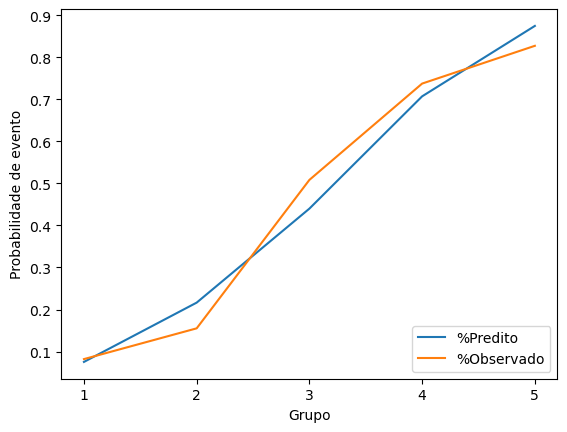

In [215]:
# Prepara a figura na qual é inserido o gráfico
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Insere no gráfico os valores médios preditos
ax = calibragem['Prob_média'].plot(label='%Predito')

# Insere no gráfico os valores médios observados
ax = calibragem['Taxa_eventos'].plot(label='%Observado')

# Formata os eixos do gráfico
ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

O gráfico da calibragem não mostra uma boa concordância entre os valores preditos pelo modelo com os observados, uma vez que há maiores desvios na curva %Observado em comparação à curva %Predito.

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [216]:
# Calcula a acurácia do ajuste
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)

#Calcula o fator AUC do ajuste a partir do ROC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

#Obtém o Gini a partir do AUC
gini = 2*auc_ -1

#Calcula o KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

# Imprime os valores resultantes
print('Acurácia: {0:.2f}% \nGINI: {1:.2f}%  \nKS: {2:.2f}%'.format(acc*100, gini*100, ks*100))

Acurácia: 79.12% 
GINI: 69.74%  
KS: 58.52%


A Discriminação do modelo apresentou valores baixos para os parâmentros, principalmente para o KS, sendo próximo de 59%. Isso mostra que este modelo pode facilmente dar resultados preditos errados (dizer que alguém saudável está doente ou o contrário).

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

Para melhorar o modelo, vejamos todas as variáveis do dataframe, e selecionar as adequadas para o ajuste.

In [217]:
# Lista com os nomes das variáveis presentes no Dataframe
variaveis = [i for i in df.columns]

# Imprime a lista
print(variaveis)

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'flag_doente', 'predito']


No modelo não há necessidade de usar a variável 'num', uma vez que essa informa qual tipo de doença a pessoa apresentou, com isso já sendo mostrado pela variável 'flag_doente. Além disso, também não serão usados os valores preditos pelo modelo anterior, excluindo a coluna 'predito' do novo ajuste.

Selecionando as variáveis restantes e criando o modelo:

In [218]:
# Seleção das variáveis que serão utilizadas no ajuste, separando as categoricas por seus valores
termos = '''flag_doente ~ sex + C(cp, Treatment(4)) + age + trestbps + chol+ 
          fbs + C(restecg) + thalach + exang + oldpeak + C(slope) + ca + thal''' 

In [219]:
# Faz a regressão logística da variável resposta 'flag_doente' em relação às variáveis selecionadas em 'termo'
regressao = smf.logit(termos, data=df).fit()

# Mostra os resultados do ajuste
regressao.summary()

Optimization terminated successfully.
         Current function value: 0.308251
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      276
Method:                           MLE   Df Model:                           20
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.5534
Time:                        14:06:55   Log-Likelihood:                -91.551
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 5.120e-37
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.8807      2.760     -1.406      0.160      -9.290       1.528
C(cp, Treatment(4))[T.1.0]    -2.3733      0.709     -3.347      0.001      -3.763      -0.983
C(cp, Treatment(4))[T.2.0]    -0.9249      0.572     -1.617      0.106      -2.046       0.197
C(cp, Treatment(4))[T.3.0]    -1.9799      0.524     -3.780      0.000      -3.007      -0.953
C(restecg)[T.1.0]              1.0009      2.638      0.379      0.704      -4.170       6.172
C(restecg)[T.2.0]              0.4864      0.396      1.227      0.220      -0.290       1.263
C(slope)[T.2.0]                1.3023      0.486      2.679      0.007       0.349       2.255
C(slope)[T.3.0]                0.6068      0.939      0.646      0.518      -1.234       2.448
ca[T.1.0]                      2.2374      0.515      4.346      0.000       1.229       3.246
ca[T.2.0]                      3.2719      0.785      4.167      0.000       1.733       4.811
ca[T.3.0]                      2.1887      0.929      2.357      0.018       0.369       4.009
thal[T.6.0]                   -0.1684      0.810     -0.208      0.835      -1.757       1.420
thal[T.7.0]                    1.4333      0.441      3.253      0.001       0.570       2.297
sex                            1.6702      0.552      3.023      0.003       0.587       2.753
age                           -0.0235      0.025     -0.936      0.349      -0.073       0.026
trestbps                       0.0277      0.012      2.359      0.018       0.005       0.051
chol                           0.0044      0.004      1.087      0.277      -0.004       0.012
fbs                           -0.5741      0.593     -0.969      0.333      -1.735       0.587
thalach                       -0.0197      0.012     -1.681      0.093      -0.043       0.003
exang                          0.6533      0.447      1.460      0.144      -0.224       1.530
oldpeak                        0.3907      0.239      1.633      0.102      -0.078       0.859
==============================================================================================
"""

Antes de remover qualquer variável do ajuste, vamos pegar como referência das categóricas os valores que apresentaram menor p-value. Sendo mais específico, na tomemos o valor 7.0 para a variável 'thal'; 2.0 para a 'slope' e 2.0 para 'restecg'.

In [220]:
# Seleção das variáveis que serão utilizadas no ajuste, separando as categoricas por seus valores
termos = '''flag_doente ~ sex + C(cp, Treatment(4)) + age + trestbps + chol+ 
            fbs + C(restecg, Treatment(2)) + thalach + exang + oldpeak + 
            C(slope, Treatment(2)) + ca + C(thal, Treatment(2))''' 

In [221]:
# Faz a regressão logística da variável resposta 'flag_doente' em relação às variáveis selecionadas em 'termo'
regressao = smf.logit(termos, data=df).fit()

# Mostra os resultados do ajuste
regressao.summary()

Optimization terminated successfully.
         Current function value: 0.308251
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      276
Method:                           MLE   Df Model:                           20
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.5534
Time:                        14:06:55   Log-Likelihood:                -91.551
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 5.120e-37
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.6587      2.779     -0.237      0.813      -6.105       4.788
C(cp, Treatment(4))[T.1.0]         -2.3733      0.709     -3.347      0.001      -3.763      -0.983
C(cp, Treatment(4))[T.2.0]         -0.9249      0.572     -1.617      0.106      -2.046       0.197
C(cp, Treatment(4))[T.3.0]         -1.9799      0.524     -3.780      0.000      -3.007      -0.953
C(restecg, Treatment(2))[T.0.0]    -0.4864      0.396     -1.227      0.220      -1.263       0.290
C(restecg, Treatment(2))[T.1.0]     0.5145      2.638      0.195      0.845      -4.655       5.684
C(slope, Treatment(2))[T.1.0]      -1.3023      0.486     -2.679      0.007      -2.255      -0.349
C(slope, Treatment(2))[T.3.0]      -0.6955      0.873     -0.797      0.425      -2.406       1.015
ca[T.1.0]                           2.2374      0.515      4.346      0.000       1.229       3.246
ca[T.2.0]                           3.2719      0.785      4.167      0.000       1.733       4.811
ca[T.3.0]                           2.1887      0.929      2.357      0.018       0.369       4.009
C(thal, Treatment(2))[T.3.0]       -1.4333      0.441     -3.253      0.001      -2.297      -0.570
C(thal, Treatment(2))[T.6.0]       -1.6018      0.795     -2.015      0.044      -3.160      -0.044
sex                                 1.6702      0.552      3.023      0.003       0.587       2.753
age                                -0.0235      0.025     -0.936      0.349      -0.073       0.026
trestbps                            0.0277      0.012      2.359      0.018       0.005       0.051
chol                                0.0044      0.004      1.087      0.277      -0.004       0.012
fbs                                -0.5741      0.593     -0.969      0.333      -1.735       0.587
thalach                            -0.0197      0.012     -1.681      0.093      -0.043       0.003
exang                               0.6533      0.447      1.460      0.144      -0.224       1.530
oldpeak                             0.3907      0.239      1.633      0.102      -0.078       0.859
===================================================================================================
"""

A variável que apresentou pior p-value foi a 'restecg', mesmo após a seleção do valor de referência. Vamos removê-la.

In [222]:
# Seleção das variáveis que serão utilizadas no ajuste, separando as categoricas por seus valores
termos = '''flag_doente ~ sex + C(cp, Treatment(4)) + age + trestbps + chol+ 
            fbs + thalach + exang + oldpeak + 
            C(slope, Treatment(2)) + ca + C(thal, Treatment(2))''' 

In [223]:
# Faz a regressão logística da variável resposta 'flag_doente' em relação às variáveis selecionadas em 'termo'
regressao = smf.logit(termos, data=df).fit()

# Mostra os resultados do ajuste
regressao.summary()

Optimization terminated successfully.
         Current function value: 0.310952
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      278
Method:                           MLE   Df Model:                           18
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.5494
Time:                        14:06:56   Log-Likelihood:                -92.353
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 8.484e-38
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.4329      2.698     -0.531      0.595      -6.722       3.856
C(cp, Treatment(4))[T.1.0]       -2.3310      0.701     -3.327      0.001      -3.704      -0.958
C(cp, Treatment(4))[T.2.0]       -0.9481      0.573     -1.655      0.098      -2.071       0.175
C(cp, Treatment(4))[T.3.0]       -1.9980      0.524     -3.817      0.000      -3.024      -0.972
C(slope, Treatment(2))[T.1.0]    -1.3534      0.483     -2.799      0.005      -2.301      -0.406
C(slope, Treatment(2))[T.3.0]    -0.6643      0.849     -0.782      0.434      -2.328       1.000
ca[T.1.0]                         2.2856      0.513      4.457      0.000       1.281       3.291
ca[T.2.0]                         3.2127      0.771      4.165      0.000       1.701       4.725
ca[T.3.0]                         2.2310      0.949      2.350      0.019       0.371       4.091
C(thal, Treatment(2))[T.3.0]     -1.3574      0.432     -3.144      0.002      -2.204      -0.511
C(thal, Treatment(2))[T.6.0]     -1.6034      0.786     -2.040      0.041      -3.144      -0.063
sex                               1.7173      0.546      3.143      0.002       0.646       2.788
age                              -0.0212      0.025     -0.849      0.396      -0.070       0.028
trestbps                          0.0286      0.012      2.474      0.013       0.006       0.051
chol                              0.0053      0.004      1.333      0.183      -0.003       0.013
fbs                              -0.5799      0.589     -0.985      0.325      -1.734       0.574
thalach                          -0.0195      0.012     -1.665      0.096      -0.043       0.003
exang                             0.6519      0.447      1.459      0.145      -0.224       1.528
oldpeak                           0.3829      0.233      1.645      0.100      -0.073       0.839
=================================================================================================
"""

Apesar da variável 'age' ter apresentado um p-value aceitável no ajuste inicial, vemos que na presença das outras variáveis, ela apresenta o maior p-value. Vamos removê-la deste ajuste.

In [224]:
# Seleção das variáveis que serão utilizadas no ajuste, separando as categoricas por seus valores
termos = '''flag_doente ~ sex + C(cp, Treatment(4)) +  trestbps + chol+ 
            fbs + thalach + exang + oldpeak + 
            C(slope, Treatment(2)) + ca + C(thal, Treatment(2))''' 

In [225]:
# Faz a regressão logística da variável resposta 'flag_doente' em relação às variáveis selecionadas em 'termo'
regressao = smf.logit(termos, data=df).fit()

# Mostra os resultados do ajuste
regressao.summary()

Optimization terminated successfully.
         Current function value: 0.312172
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                           17
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.5477
Time:                        14:06:56   Log-Likelihood:                -92.715
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 3.207e-38
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.5948      2.320     -1.119      0.263      -7.141       1.952
C(cp, Treatment(4))[T.1.0]       -2.3442      0.696     -3.369      0.001      -3.708      -0.980
C(cp, Treatment(4))[T.2.0]       -0.9694      0.572     -1.696      0.090      -2.090       0.151
C(cp, Treatment(4))[T.3.0]       -2.0262      0.523     -3.872      0.000      -3.052      -1.001
C(slope, Treatment(2))[T.1.0]    -1.3223      0.481     -2.751      0.006      -2.264      -0.380
C(slope, Treatment(2))[T.3.0]    -0.6572      0.850     -0.773      0.439      -2.323       1.008
ca[T.1.0]                         2.2084      0.503      4.390      0.000       1.222       3.194
ca[T.2.0]                         3.0295      0.738      4.104      0.000       1.583       4.476
ca[T.3.0]                         2.1041      0.947      2.222      0.026       0.248       3.960
C(thal, Treatment(2))[T.3.0]     -1.3531      0.430     -3.145      0.002      -2.196      -0.510
C(thal, Treatment(2))[T.6.0]     -1.6001      0.783     -2.043      0.041      -3.135      -0.065
sex                               1.7403      0.543      3.206      0.001       0.676       2.804
trestbps                          0.0257      0.011      2.351      0.019       0.004       0.047
chol                              0.0047      0.004      1.227      0.220      -0.003       0.012
fbs                              -0.5730      0.585     -0.979      0.327      -1.720       0.574
thalach                          -0.0161      0.011     -1.468      0.142      -0.038       0.005
exang                             0.6576      0.445      1.478      0.139      -0.215       1.530
oldpeak                           0.4050      0.231      1.754      0.079      -0.048       0.858
=================================================================================================
"""

Foi notada uma piora no p-value da variável 'chol' com a remoção da 'age'. Ainda assim, a 'fbs' apresenta o valor mais alto. Vamos remover esta agora.

In [226]:
# Seleção das variáveis que serão utilizadas no ajuste, separando as categoricas por seus valores
termos = '''flag_doente ~ sex + C(cp, Treatment(4)) +  trestbps + chol+ 
            thalach + exang + oldpeak + 
            C(slope, Treatment(2)) + ca + C(thal, Treatment(2))''' 

In [227]:
# Faz a regressão logística da variável resposta 'flag_doente' em relação às variáveis selecionadas em 'termo'
regressao = smf.logit(termos, data=df).fit()

# Mostra os resultados do ajuste
regressao.summary()

Optimization terminated successfully.
         Current function value: 0.313812
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      280
Method:                           MLE   Df Model:                           16
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.5453
Time:                        14:06:56   Log-Likelihood:                -93.202
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 1.325e-38
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.2949      2.281     -1.006      0.314      -6.766       2.177
C(cp, Treatment(4))[T.1.0]       -2.4204      0.696     -3.480      0.001      -3.784      -1.057
C(cp, Treatment(4))[T.2.0]       -0.9924      0.566     -1.755      0.079      -2.101       0.116
C(cp, Treatment(4))[T.3.0]       -2.1265      0.516     -4.124      0.000      -3.137      -1.116
C(slope, Treatment(2))[T.1.0]    -1.2890      0.478     -2.695      0.007      -2.226      -0.351
C(slope, Treatment(2))[T.3.0]    -0.6987      0.851     -0.821      0.411      -2.366       0.968
ca[T.1.0]                         2.1432      0.493      4.346      0.000       1.177       3.110
ca[T.2.0]                         2.9434      0.728      4.043      0.000       1.516       4.370
ca[T.3.0]                         1.9612      0.918      2.137      0.033       0.162       3.760
C(thal, Treatment(2))[T.3.0]     -1.3555      0.428     -3.168      0.002      -2.194      -0.517
C(thal, Treatment(2))[T.6.0]     -1.6808      0.777     -2.164      0.030      -3.203      -0.158
sex                               1.7081      0.542      3.150      0.002       0.645       2.771
trestbps                          0.0241      0.011      2.238      0.025       0.003       0.045
chol                              0.0045      0.004      1.179      0.238      -0.003       0.012
thalach                          -0.0163      0.011     -1.490      0.136      -0.038       0.005
exang                             0.6227      0.444      1.404      0.160      -0.247       1.492
oldpeak                           0.4257      0.231      1.846      0.065      -0.026       0.877
=================================================================================================
"""

O p-value da variável 'chol' continua altíssimo para o ajuste. Vejamos sem ela.

In [228]:
# Seleção das variáveis que serão utilizadas no ajuste, separando as categoricas por seus valores
termos = '''flag_doente ~ sex + C(cp, Treatment(4)) +  trestbps +  
            thalach + exang + oldpeak + 
            C(slope, Treatment(2)) + ca + C(thal, Treatment(2))''' 

In [229]:
# Faz a regressão logística da variável resposta 'flag_doente' em relação às variáveis selecionadas em 'termo'
regressao = smf.logit(termos, data=df).fit()

# Mostra os resultados do ajuste
regressao.summary()

Optimization terminated successfully.
         Current function value: 0.316064
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      281
Method:                           MLE   Df Model:                           15
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.5420
Time:                        14:06:56   Log-Likelihood:                -93.871
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 6.307e-39
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.3827      2.105     -0.657      0.511      -5.509       2.744
C(cp, Treatment(4))[T.1.0]       -2.4416      0.692     -3.528      0.000      -3.798      -1.085
C(cp, Treatment(4))[T.2.0]       -0.9782      0.564     -1.734      0.083      -2.084       0.128
C(cp, Treatment(4))[T.3.0]       -2.1346      0.515     -4.148      0.000      -3.143      -1.126
C(slope, Treatment(2))[T.1.0]    -1.3141      0.477     -2.754      0.006      -2.249      -0.379
C(slope, Treatment(2))[T.3.0]    -0.7516      0.845     -0.889      0.374      -2.408       0.905
ca[T.1.0]                         2.1620      0.493      4.384      0.000       1.195       3.129
ca[T.2.0]                         2.9408      0.723      4.068      0.000       1.524       4.358
ca[T.3.0]                         2.0043      0.897      2.234      0.026       0.246       3.763
C(thal, Treatment(2))[T.3.0]     -1.3746      0.428     -3.208      0.001      -2.214      -0.535
C(thal, Treatment(2))[T.6.0]     -1.7496      0.767     -2.281      0.023      -3.253      -0.246
sex                               1.5549      0.522      2.977      0.003       0.531       2.578
trestbps                          0.0249      0.011      2.329      0.020       0.004       0.046
thalach                          -0.0149      0.011     -1.394      0.163      -0.036       0.006
exang                             0.6306      0.439      1.435      0.151      -0.231       1.492
oldpeak                           0.4428      0.229      1.930      0.054      -0.007       0.892
=================================================================================================
"""

A variável 'trelach' não está bem ajustada. Removendo-a do ajuste:

In [230]:
# Seleção das variáveis que serão utilizadas no ajuste, separando as categoricas por seus valores
termos = '''flag_doente ~ sex + C(cp, Treatment(4)) +  trestbps +  
             exang + oldpeak + 
            C(slope, Treatment(2)) + ca + C(thal, Treatment(2))''' 

In [231]:
# Faz a regressão logística da variável resposta 'flag_doente' em relação às variáveis selecionadas em 'termo'
regressao = smf.logit(termos, data=df).fit()

# Mostra os resultados do ajuste
regressao.summary()

Optimization terminated successfully.
         Current function value: 0.319469
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      282
Method:                           MLE   Df Model:                           14
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.5371
Time:                        14:06:56   Log-Likelihood:                -94.882
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 4.031e-39
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.3761      1.586     -2.129      0.033      -6.484      -0.268
C(cp, Treatment(4))[T.1.0]       -2.5452      0.693     -3.673      0.000      -3.904      -1.187
C(cp, Treatment(4))[T.2.0]       -1.0818      0.558     -1.938      0.053      -2.176       0.012
C(cp, Treatment(4))[T.3.0]       -2.2258      0.509     -4.375      0.000      -3.223      -1.229
C(slope, Treatment(2))[T.1.0]    -1.4763      0.461     -3.201      0.001      -2.380      -0.572
C(slope, Treatment(2))[T.3.0]    -0.8558      0.817     -1.047      0.295      -2.458       0.746
ca[T.1.0]                         2.2681      0.486      4.663      0.000       1.315       3.221
ca[T.2.0]                         2.9231      0.727      4.018      0.000       1.497       4.349
ca[T.3.0]                         2.2095      0.891      2.480      0.013       0.464       3.955
C(thal, Treatment(2))[T.3.0]     -1.4222      0.426     -3.340      0.001      -2.257      -0.588
C(thal, Treatment(2))[T.6.0]     -1.6210      0.756     -2.144      0.032      -3.103      -0.139
sex                               1.4509      0.508      2.856      0.004       0.455       2.447
trestbps                          0.0239      0.011      2.219      0.026       0.003       0.045
exang                             0.7267      0.432      1.683      0.092      -0.120       1.573
oldpeak                           0.4714      0.228      2.067      0.039       0.024       0.918
=================================================================================================
"""

Vemos que, com exceção das variáveis 'exang' e  'C(slope, Treatment(2))[T.3.0]', todas apresentaram um p-value infeiror a 5%, de forma que elas estão em concordância com o ajuste. Tomando como limite p-value de 10%, apenas a categoria 3 da variável slope está fora do ajuste. Uma vez que não há como remover esta coluna do ajuste, vamos mantê-la e analisar a calibragem e a acurácia deste último ajuste.

#### Calibragem

In [232]:
# Coluna com a probabilidade de evento predita
df['predito2'] = regressao.predict(df)

# 5 primeiras linhas da tabela resultante
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito,predito2
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458086,0.083516
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.942756,0.984048
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.884350,0.997041
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.139590,0.158378
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.028736,0.026917


In [233]:
# Divide a coluna 'predito' em 5 categorias, removendo os valores duplicados
cat_pred = pd.qcut(df['predito2'], 5, duplicates='drop')

# Mostra a quantidade de itens em cada grupo, mostrando as faixas de predito em forma crescente
cat_pred.value_counts().sort_index()

(0.00092, 0.0466]    60
(0.0466, 0.217]      59
(0.217, 0.582]       59
(0.582, 0.947]       59
(0.947, 0.999]       60
Name: predito2, dtype: int64

In [234]:
# Agrupa os dados da tabela de acordo com a faixa do valor predito
grupos_pred = df.groupby(cat_pred)

# Faz a contagem de elementos em cada categoria da variável 'predito'
calibragem = grupos_pred[['flag_doente']].count().rename(columns = {'flag_doente': 'Contagem'})

# Calcula a probabilidade de evento média por grupo
calibragem['Prob_média'] = grupos_pred['predito2'].mean()

# Calcula a taxa de eventos por grupo
calibragem['Taxa_eventos'] = grupos_pred['flag_doente'].mean()

# Mostra os valores resultantes da calibragem
calibragem

,Contagem,Prob_média,Taxa_eventos
predito2,,,
"(0.00092, 0.0466]",60,0.021300,0.066667
"(0.0466, 0.217]",59,0.116844,0.050847
"(0.217, 0.582]",59,0.372736,0.355932
"(0.582, 0.947]",59,0.810560,0.847458
"(0.947, 0.999]",60,0.983562,0.983333


Text(0.5, 0, 'Grupo')

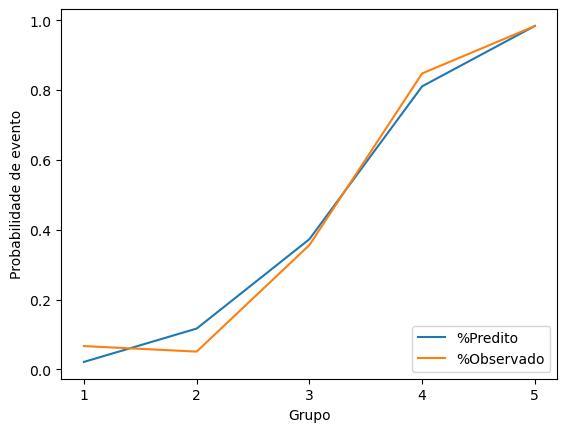

In [235]:
# Prepara a figura na qual é inserido o gráfico
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Insere no gráfico os valores médios preditos
ax = calibragem['Prob_média'].plot(label='%Predito')

# Insere no gráfico os valores médios observados
ax = calibragem['Taxa_eventos'].plot(label='%Observado')

# Formata os eixos do gráfico
ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

#### Discriminação

In [236]:
# Calcula a acurácia do ajuste
acc = metrics.accuracy_score(df['flag_doente'], df['predito2']>.5)

# Calcula o fator AUC do ajuste a partir do ROC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito2'])
auc_ = metrics.auc(fpr, tpr)

# Obtém o Gini a partir do AUC
gini = 2*auc_ -1

# Calcula o KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito2'], df.loc[df['flag_doente'] != 1, 'predito2']).statistic

# Imprime os valores resultantes
print('Acurácia: {0:.2f}% \nGINI: {1:.2f}%  \nKS: {2:.2f}%'.format(acc*100, gini*100, ks*100))

Acurácia: 88.89% 
GINI: 87.21%  
KS: 77.90%


O gráfico da **Calibragem** mostra que os valores preditos estão bem mais próximos dos observados quando comparados ao modelo inicial, tanto que há uma semelhança maior entre as curvas %Predito e %Observado. Além disso, os fatores de **Discriminação**, ficaram muito mais próximos de 1 quando comparado aos do modelo inicial, com destaque ao **KS** que foi de 59% para 78%. Dessa forma, pode-se afirmar que o novo modelo é superior ao inicial, sem ser um caso de _overfitting_, dado que foi usada uma maior quantidade de variáveis explicativas.